# Neural Networks

#### Dealing with dataset imbalance for a binary classification model

## By Brea Koenes

### Overview

I create a neural network to perform a binary classification on a coronavirus dataset.

### Imports

In [2]:
# Imports
import subprocess
import sys
from IPython.display import clear_output
import numpy as np
import pandas as pd
import sklearn
import tensorflow

# For splitting datasets
from sklearn.model_selection import train_test_split

# For building neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Data Prep

The coronavirus dataset is included in the `corona.csv` file. Read the data into a pandas DataFrame called `covid`.

In [3]:
# STUDENTS CODE
covid = pd.read_csv("corona.csv", encoding='utf-8')
covid

/var/folders/4b/b70j92ld2vn9nmjfb_8tgdgh0000gp/T/ipykernel_56270/1055299547.py:2: DtypeWarning: Columns (2,3,4,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  covid = pd.read_csv("corona.csv", encoding='utf-8')


,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Age_60_above,Sex,Known_contact
0,1,11-03-2020,True,False,True,False,False,negative,NaN,NaN,Abroad
1,2,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
2,3,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
3,4,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Abroad
4,5,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Contact with confirmed
...,...,...,...,...,...,...,...,...,...,...,...
278843,278844,30-04-2020,False,False,False,False,False,positive,NaN,male,Other
278844,278845,30-04-2020,False,False,False,False,False,negative,NaN,female,Other
278845,278846,30-04-2020,False,False,False,False,False,negative,NaN,male,Other
278846,278847,30-04-2020,False,False,False,False,False,negative,NaN,male,Other


Clean and preprocess the data:
- Drop NULL values.
- Change the datatypes of each column to binary, float64 columns.
- Drop rows where the value in the `Corona` column is `other`.
- Split the dataframe into 2: `symptoms`, which contains the features of the dataset, and `diagnosis`, which contains only the target column, `Corona`.
- Generate `x_train`, `x_test`, `y_train`, and `y_test`. Reserve 20% of the data for testing and set the `stratify` parameter to `diagnosis`.

In [4]:
# Drop nulls
covid = covid.dropna()

# Check
print(covid.isna().sum())

Ind_ID                 0
Test_date              0
Cough_symptoms         0
Fever                  0
Sore_throat            0
Shortness_of_breath    0
Headache               0
Corona                 0
Age_60_above           0
Sex                    0
Known_contact          0
dtype: int64


In [5]:
# Check for columns that have binary rows
for column in covid.columns:
    print(f"Unique values in '{column}': {covid[column].unique()}")

Unique values in 'Ind_ID': [ 13728  13729  13731 ... 156038 156039 156040]
Unique values in 'Test_date': ['22-03-2020' '23-03-2020' '24-03-2020' '25-03-2020' '26-03-2020'
 '27-03-2020' '28-03-2020' '29-03-2020' '30-03-2020' '31-03-2020'
 '01-04-2020' '02-04-2020' '03-04-2020' '04-04-2020' '05-04-2020'
 '06-04-2020' '07-04-2020' '08-04-2020' '09-04-2020' '10-04-2020'
 '11-04-2020' '12-04-2020' '13-04-2020' '14-04-2020']
Unique values in 'Cough_symptoms': [True False]
Unique values in 'Fever': [False True]
Unique values in 'Sore_throat': [False True]
Unique values in 'Shortness_of_breath': [False True]
Unique values in 'Headache': [False True]
Unique values in 'Corona': ['negative' 'positive' 'other']
Unique values in 'Age_60_above': ['No' 'Yes']
Unique values in 'Sex': ['male' 'female']
Unique values in 'Known_contact': ['Abroad' 'Other' 'Contact with confirmed']


In [6]:
# Convert columns to binary (float64)
true_false_columns = ['Cough_symptoms', 'Fever', 'Sore_throat', 'Shortness_of_breath', 'Headache']
covid.loc[:, true_false_columns] = covid[true_false_columns].replace({'True': 1.0, 'False': 0.0}).astype('float64')

covid.loc[:, 'Age_60_above'] = covid['Age_60_above'].replace({'Yes': 1, 'No': 0}).astype(float)
covid.loc[:, 'Sex'] = covid['Sex'].replace({'male': 1, 'female': 0}).astype(float)

covid = covid[covid['Known_contact'] != 'Other']

covid.loc[:, 'Known_contact'] = covid['Known_contact'].replace({'Abroad': 0, 'Contact with confirmed': 1}).astype(float)

covid = covid[covid['Corona'] != 'other']
covid.loc[:, 'Corona'] = covid['Corona'].replace({'positive': 1.0, 'negative': 0.0}).astype('float64')

# Split the data into features and target 
symptoms = covid[['Cough_symptoms', 'Fever', 'Sore_throat', 'Shortness_of_breath', 'Sex', 'Headache', 'Known_contact', 'Age_60_above']].astype('float64')
diagnosis = covid['Corona'].astype('float64')

# Convert to numpy arrays
x = symptoms.values  # Features
y = diagnosis.values  # Target

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

### Training the Binary Classifier

Create a neural network for binary classification with the covid data, with one input layer and one output layer.

In [7]:
# Create the model
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))  # Input layer and hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Use training and testing data to train the model. Plot the validation and training accuracy and the confusion matrix.

In [8]:
# Train the model
hist = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=100, 
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/10
  1/176 [..............................] - ETA: 33s - loss: 0.6642 - accuracy: 0.7200

2025-01-22 14:38:39.744847: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


176/176 [==============================] - 0s 604us/step - loss: 0.4312 - accuracy: 0.8425 - val_loss: 0.3502 - val_accuracy: 0.8642
Epoch 2/10
176/176 [==============================] - 0s 314us/step - loss: 0.3362 - accuracy: 0.8695 - val_loss: 0.3408 - val_accuracy: 0.8683
Epoch 3/10
176/176 [==============================] - 0s 302us/step - loss: 0.3322 - accuracy: 0.8712 - val_loss: 0.3386 - val_accuracy: 0.8683
Epoch 4/10
176/176 [==============================] - 0s 300us/step - loss: 0.3307 - accuracy: 0.8719 - val_loss: 0.3371 - val_accuracy: 0.8696
Epoch 5/10
176/176 [==============================] - 0s 302us/step - loss: 0.3300 - accuracy: 0.8721 - val_loss: 0.3379 - val_accuracy: 0.8696
Epoch 6/10
176/176 [==============================] - 0s 305us/step - loss: 0.3291 - accuracy: 0.8725 - val_loss: 0.3370 - val_accuracy: 0.8696
Epoch 7/10
176/176 [==============================] - 0s 296us/step - loss: 0.3286 - accuracy: 0.8724 - val_loss: 0.3348 - val_accuracy: 0.8696
Epo

In [9]:
print(hist.history)

{'loss': [0.4311615526676178, 0.3362211585044861, 0.3321753144264221, 0.3307146728038788, 0.3299873173236847, 0.32907113432884216, 0.3285982012748718, 0.32790714502334595, 0.3278546631336212, 0.32683584094047546], 'accuracy': [0.8425461649894714, 0.8695008158683777, 0.8711534142494202, 0.8718942403793335, 0.8721221685409546, 0.872464120388031, 0.8724071383476257, 0.8724071383476257, 0.8724071383476257, 0.8723500967025757], 'val_loss': [0.3502226173877716, 0.34075894951820374, 0.3385748565196991, 0.3370833992958069, 0.33789345622062683, 0.3369944095611572, 0.334826797246933, 0.3354950249195099, 0.33457082509994507, 0.3351745307445526], 'val_accuracy': [0.864175021648407, 0.8682771325111389, 0.8682771325111389, 0.8696444630622864, 0.8696444630622864, 0.8696444630622864, 0.8696444630622864, 0.8696444630622864, 0.8696444630622864, 0.8696444630622864]}


[]

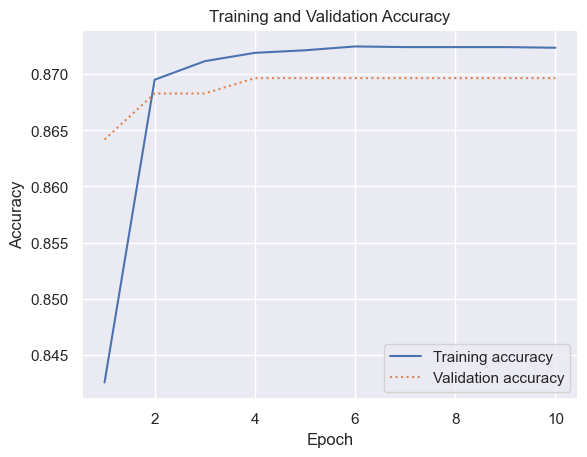

In [10]:
# Plot accuracy
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

138/138 [==============================] - 0s 156us/step
Accuracy: 0.8696
Recall: 0.7598
F1 Score: 0.7759
Precision: 0.7926


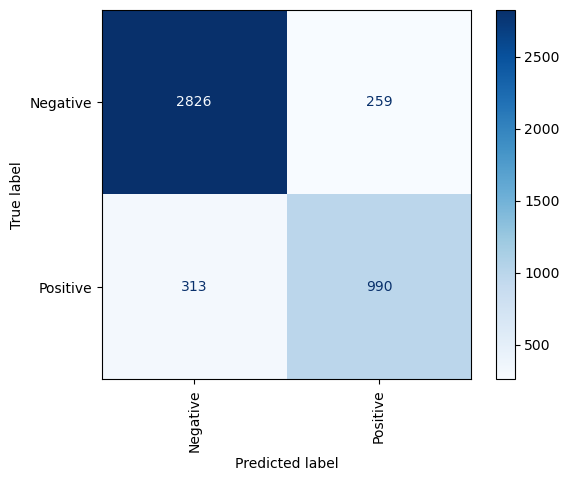

In [11]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, ConfusionMatrixDisplay


sns.reset_orig()
y_predicted = model.predict(x_test) > 0.5

accuracy = accuracy_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")


labels = ['Negative', 'Positive']
cmd.from_predictions(y_test, y_predicted, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

This confusion matrix makes it clear that we have more false negative diagnoses than false positive diagnoses. That's not what we want, so I'll take a closer look at the data.

### Dealing with Dataset Imbalance

Look at the `value_counts` for the `Corona` column in the original `covid` dataset.

In [12]:
covid['Corona'].value_counts()

Corona
0.0    15420
1.0     6516
Name: count, dtype: int64

There is an imbalance in our data. I'll retrain the neural network for binary classification, and this time use the `class_weights` paramater of the `.fit()` method to try and handle the imbalanced nature of the data.

Compute the class weight for each of the classes and store them in a dictionary where the key is the binary value representing the class and the value is that class' weight. Then, retrain the neural network with the `class_weight` set to the dictionary. Plot the accuracy and confusion matrix.

In [13]:
# Compute the class frequencies
class_counts = covid['Corona'].value_counts()
n_samples = len(covid)
n_classes = 2  # Binary classification

# Calculate the class weights based on the formula
class_weights = {0: n_samples / (n_classes * class_counts[0]),  # For 'negative' class
                 1: n_samples / (n_classes * class_counts[1])}  # For 'positive' class

print("Class weights:", class_weights)

# Train the model with class_weights
hist = model.fit(x_train, y_train, 
                 epochs=10, 
                 batch_size=100, 
                 validation_data=(x_test, y_test),
                 class_weight=class_weights,  # Add class weights here
                 verbose=1)

Class weights: {0: 0.711284046692607, 1: 1.6832412523020257}
Epoch 1/10
176/176 [==============================] - 0s 397us/step - loss: 0.3738 - accuracy: 0.8541 - val_loss: 0.3707 - val_accuracy: 0.8457
Epoch 2/10
176/176 [==============================] - 0s 319us/step - loss: 0.3699 - accuracy: 0.8537 - val_loss: 0.3605 - val_accuracy: 0.8457
Epoch 3/10
176/176 [==============================] - 0s 314us/step - loss: 0.3700 - accuracy: 0.8537 - val_loss: 0.3660 - val_accuracy: 0.8457
Epoch 4/10
176/176 [==============================] - 0s 317us/step - loss: 0.3694 - accuracy: 0.8537 - val_loss: 0.3655 - val_accuracy: 0.8478
Epoch 5/10
176/176 [==============================] - 0s 316us/step - loss: 0.3698 - accuracy: 0.8538 - val_loss: 0.3717 - val_accuracy: 0.8457
Epoch 6/10
176/176 [==============================] - 0s 316us/step - loss: 0.3694 - accuracy: 0.8537 - val_loss: 0.3818 - val_accuracy: 0.8457
Epoch 7/10
176/176 [==============================] - 0s 315us/step - loss:

[]

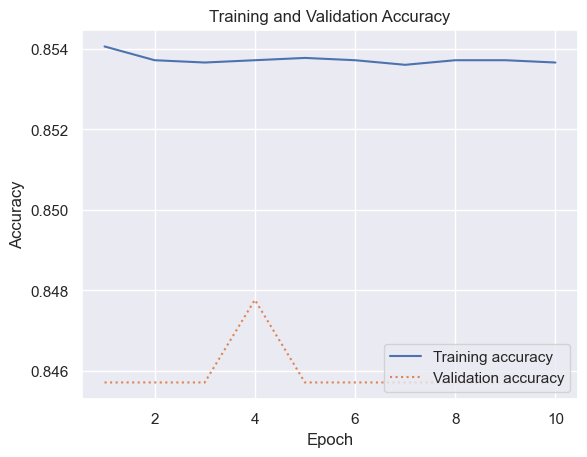

In [14]:
# Plot accuracy
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

138/138 [==============================] - 0s 152us/step
Accuracy: 0.8457
Recall: 0.8573
F1 Score: 0.7674
Precision: 0.6947


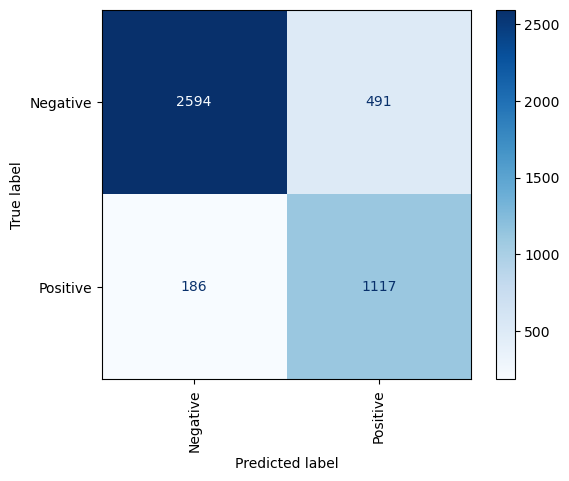

In [15]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, ConfusionMatrixDisplay

sns.reset_orig()
y_predicted = model.predict(x_test) > 0.5

accuracy = accuracy_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")

labels = ['Negative', 'Positive']
cmd.from_predictions(y_test, y_predicted, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

The retrained model performs much better: the number false negatives should be less than the number of false positives.

### Export
Export the symptoms and diagnosis datasets and model

In [16]:
import pickle

# Save dataset to file
with open('symptoms.pkl', 'wb') as file:
    pickle.dump(symptoms , file)   

with open('diagnosis.pkl', 'wb') as file:
    pickle.dump(diagnosis , file)   

In [17]:
model.save('NN_BinayClass.h5')